# Learning more on Octupoles and GPU programming

We want to study what happens the strange behaviours that appear when switching the octupoles on and off.
But first we need to understand how to program on GPUs.
XSuite makes it simpler for us but with some tweaks that need to be understood.

In [1]:
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
import json
import pandas as pd
from cpymad.madx import Madx
from matplotlib import pyplot as plt
%matplotlib inline
import NAFFlib
from math import modf

If the GPU is an NVDIA then we can use Cupy.

In [2]:
ctx2 = xo.ContextCupy()
ctx = xo.ContextCpu()

Run 3 lattice with knobs activated.

In [3]:
mad = Madx()
mad.call('andrea.madx')
mad.use(sequence="lhcb1")

GC Warning: Repeated allocation of very large block (appr. size 323584):
	May lead to memory leak and poor performance


In [4]:
#line.element_names
line = xt.Line.from_madx_sequence(mad.sequence['lhcb1'],
                                  deferred_expressions=True
                                  )

In [5]:
print(line.vars['i_mo']._get_value())
line.vars['i_mo'] = 0
print(line.vars['i_mo']._get_value())

-350.0
0


We need particles, let's define some. 
First of all we define the $\sigma_{x}$=$\sqrt{\frac{\beta_{x}\epsilon}{\gamma}}$, with $\epsilon=2\times10^{-6}$

In [6]:
gamma=7000/.938
sigma_x=np.sqrt(120.29057045*3e-6/gamma)
sigma_x

0.00021990181745701876

This particle will be used only to define the tracker, after this we'll use the Closed Orbit given by the tracker to keep track of what happens.

In [79]:
particles_3 = xp.Particles(_context=ctx2,
                        p0c=7000e9,
                        x=[1.00951707e-08],px=[1.69518015e-10],
                        y=[5.65551848e-12],py=[6.07695199e-14]
                        )

In [8]:
tracker = xt.Tracker(_context=ctx2, line=line)
tw = tracker.twiss(particles_3)

p0 will be our reference particle.

In [9]:
p0=tw['particle_on_co']
p0.x

array([0.])

Now we can define our particles starting from this one! The non explicit coordinates are set to zero.

In [10]:
particles = xp.build_particles(_context=ctx2, particle_ref=p0, x=[p0.x+0.3*sigma_x,p0.x+0.6*sigma_x,p0.x+0.9*sigma_x,
                                                                 p0.x+1.2*sigma_x,p0.x+1.6*sigma_x,p0.x+2.0*sigma_x])

We can now print some of the particles variables

In [11]:
print(particles.x[0])
print(particles.x[5])
print(particles.p0c[2])
print(particles.zeta[3])
print(particles.y[4])

6.597054523710562e-05
0.00043980363491403753
7000000000000.0
0.0
0.0


Futhermore we can save the particles into a dictionary

In [12]:
dct = particles.to_dict()
#dct

Or into a **pandas** dataframe!

In [13]:
my_df = particles.to_pandas()
my_df

,q0,mass0,p0c,gamma0,beta0,s,x,y,px,py,...,state,parent_particle_id,_rng_s1,_rng_s2,_rng_s3,_rng_s4,delta,psigma,rvv,rpp
0,1.0,9.382721e+08,7.000000e+12,7460.522541,1.0,0.0,0.000066,0.0,0.0,0.0,...,1,0,0,0,0,0,0.0,0.0,1.0,1.0
1,1.0,9.382721e+08,7.000000e+12,7460.522541,1.0,0.0,0.000132,0.0,0.0,0.0,...,1,1,0,0,0,0,0.0,0.0,1.0,1.0
2,1.0,9.382721e+08,7.000000e+12,7460.522541,1.0,0.0,0.000198,0.0,0.0,0.0,...,1,2,0,0,0,0,0.0,0.0,1.0,1.0
3,1.0,9.382721e+08,7.000000e+12,7460.522541,1.0,0.0,0.000264,0.0,0.0,0.0,...,1,3,0,0,0,0,0.0,0.0,1.0,1.0
4,1.0,9.382721e+08,7.000000e+12,7460.522541,1.0,0.0,0.000352,0.0,0.0,0.0,...,1,4,0,0,0,0,0.0,0.0,1.0,1.0
5,1.0,9.382721e+08,7.000000e+12,7460.522541,1.0,0.0,0.000440,0.0,0.0,0.0,...,1,5,0,0,0,0,0.0,0.0,1.0,1.0


Now we need to access the variables to plot them, since these are stored into the GPU we need to do the following (particles_x is just a name, you can call it as you like).

In [14]:
particles_x = ctx2.nparray_from_context_array(particles.x)
particles_px = ctx2.nparray_from_context_array(particles.px)
particles_y = ctx2.nparray_from_context_array(particles.y)
particles_py = ctx2.nparray_from_context_array(particles.py)
particles_zeta = ctx2.nparray_from_context_array(particles.zeta)
particles_delta = ctx2.nparray_from_context_array(particles.delta)

Time to track!

In [15]:
particles = xp.build_particles(_context=ctx2, particle_ref=p0, x=[p0.x+0.3*sigma_x,p0.x+0.6*sigma_x,p0.x+0.9*sigma_x,
                                                                 p0.x+1.2*sigma_x,p0.x+1.6*sigma_x,p0.x+2.0*sigma_x])
tracker = xt.Tracker(_context=ctx2, line=line)
tw = tracker.twiss(particles_3)
N=1000
#I'm tracking 6 particles in this case
N_particles=6
n_turns=1

x = [[0 for turns in range(N)] for protons in range(N_particles)] 
px = [[0 for turns in range(N)] for protons in range(N_particles)] 
y = [[0 for turns in range(N)] for protons in range(N_particles)] 
py = [[0 for turns in range(N)] for protons in range(N_particles)] 
zeta = [[0 for turns in range(N)] for protons in range(N_particles)] 
delta = [[0 for turns in range(N)] for protons in range(N_particles)] 

for ii in range(N):
    tracker.track(particles, num_turns=n_turns,turn_by_turn_monitor=False)
    for jj in range(N_particles):
        x[jj][ii] = ctx2.nparray_from_context_array(particles.x)[jj]
        px[jj][ii] = ctx2.nparray_from_context_array(particles.px)[jj]
        y[jj][ii] = ctx2.nparray_from_context_array(particles.y)[jj]
        py[jj][ii] = ctx2.nparray_from_context_array(particles.py)[jj]
        zeta[jj][ii] = ctx2.nparray_from_context_array(particles.zeta)[jj]
        delta[jj][ii] = ctx2.nparray_from_context_array(particles.delta)[jj]

In [16]:
#for ii in range(N):
    #print(x[5][ii])

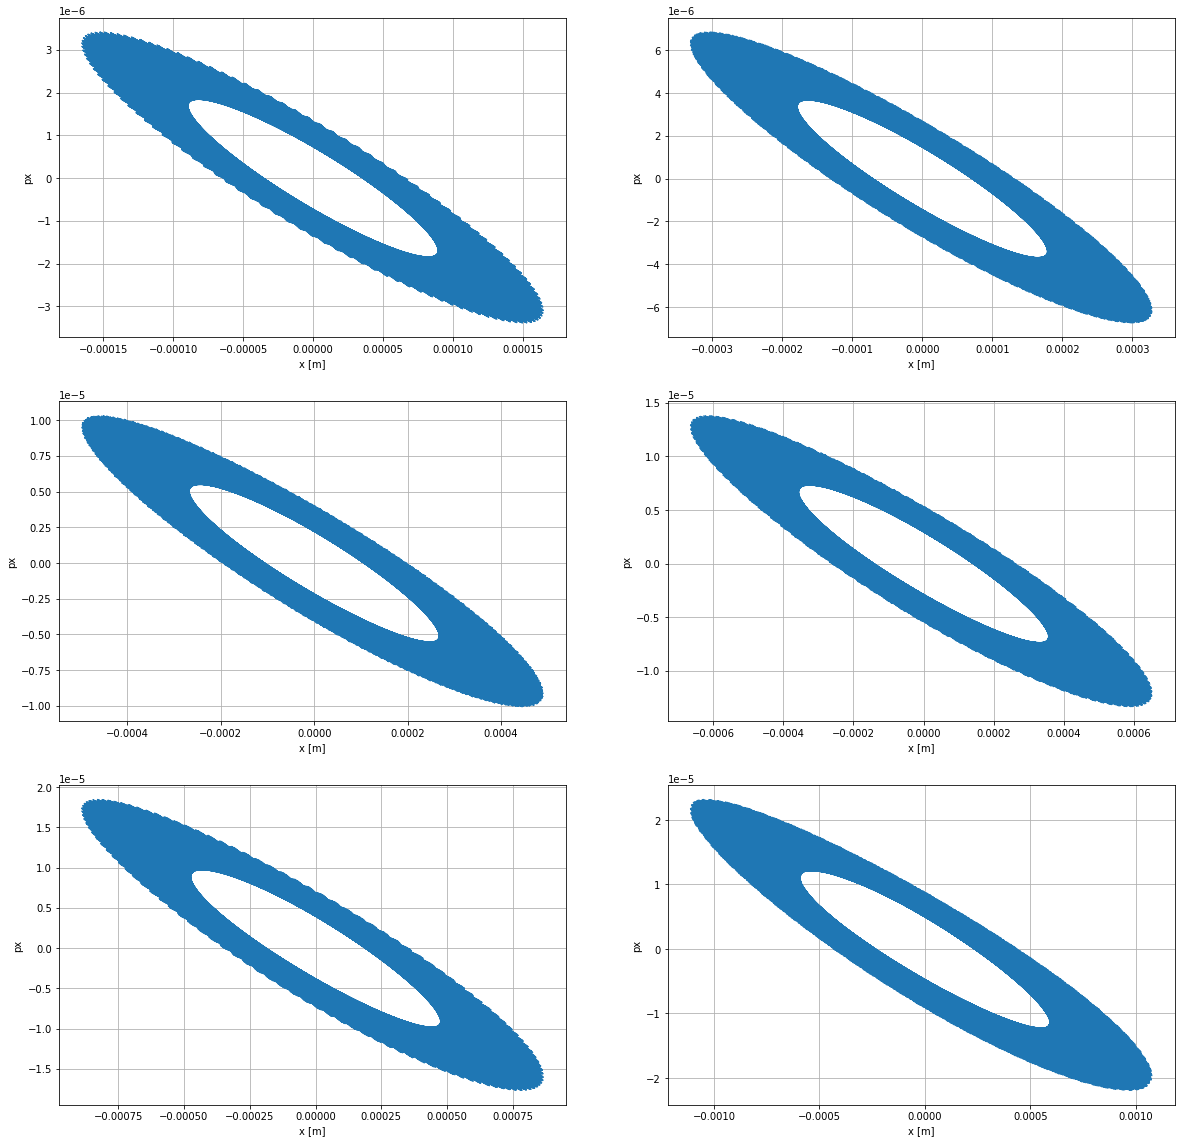

In [17]:
fig1 = plt.figure(1, figsize=(20, 20))

xtransverse1 = plt.subplot(3,2,1)
xtransverse1.plot(x[0], px[0])
xtransverse1.set_xlabel('x [m]')
xtransverse1.set_ylabel('px')
xtransverse1.grid()

xtransverse2 = plt.subplot(3,2,2)
xtransverse2.plot(x[1], px[1])
xtransverse2.set_xlabel('x [m]')
xtransverse2.set_ylabel('px')
xtransverse2.grid()

xtransverse3 = plt.subplot(3,2,3)
xtransverse3.plot(x[2], px[2])
xtransverse3.set_xlabel('x [m]')
xtransverse3.set_ylabel('px')
xtransverse3.grid()

xtransverse4 = plt.subplot(3,2,4)
xtransverse4.plot(x[3], px[3])
xtransverse4.set_xlabel('x [m]')
xtransverse4.set_ylabel('px')
xtransverse4.grid()

xtransverse5 = plt.subplot(3,2,5)
xtransverse5.plot(x[4], px[4])
xtransverse5.set_xlabel('x [m]')
xtransverse5.set_ylabel('px')
xtransverse5.grid()

xtransverse6 = plt.subplot(3,2,6)
xtransverse6.plot(x[5], px[5])
xtransverse6.set_xlabel('x [m]')
xtransverse6.set_ylabel('px')
xtransverse6.grid()

plt.show()

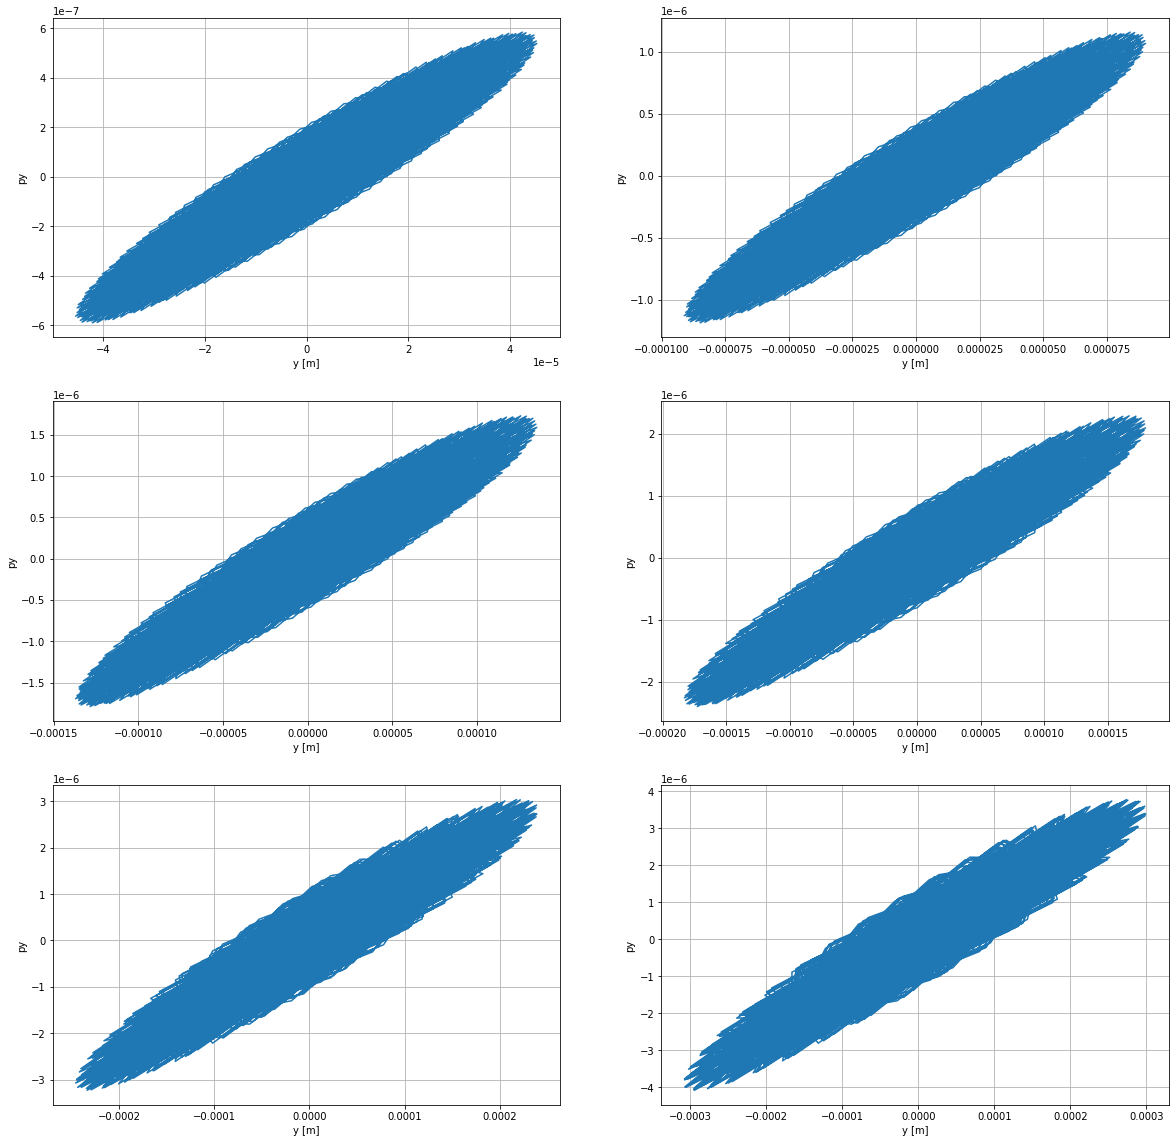

In [18]:
fig1 = plt.figure(1, figsize=(20, 20))

ytransverse1 = plt.subplot(3,2,1)
ytransverse1.plot(y[0], py[0])
ytransverse1.set_xlabel('y [m]')
ytransverse1.set_ylabel('py')
ytransverse1.grid()

ytransverse2 = plt.subplot(3,2,2)
ytransverse2.plot(y[1], py[1])
ytransverse2.set_xlabel('y [m]')
ytransverse2.set_ylabel('py')
ytransverse2.grid()

ytransverse3 = plt.subplot(3,2,3)
ytransverse3.plot(y[2], py[2])
ytransverse3.set_xlabel('y [m]')
ytransverse3.set_ylabel('py')
ytransverse3.grid()

ytransverse4 = plt.subplot(3,2,4)
ytransverse4.plot(y[3], py[3])
ytransverse4.set_xlabel('y [m]')
ytransverse4.set_ylabel('py')
ytransverse4.grid()

ytransverse5 = plt.subplot(3,2,5)
ytransverse5.plot(y[4], py[4])
ytransverse5.set_xlabel('y [m]')
ytransverse5.set_ylabel('py')
ytransverse5.grid()

ytransverse6 = plt.subplot(3,2,6)
ytransverse6.plot(y[5], py[5])
ytransverse6.set_xlabel('y [m]')
ytransverse6.set_ylabel('py')
ytransverse6.grid()

plt.show()

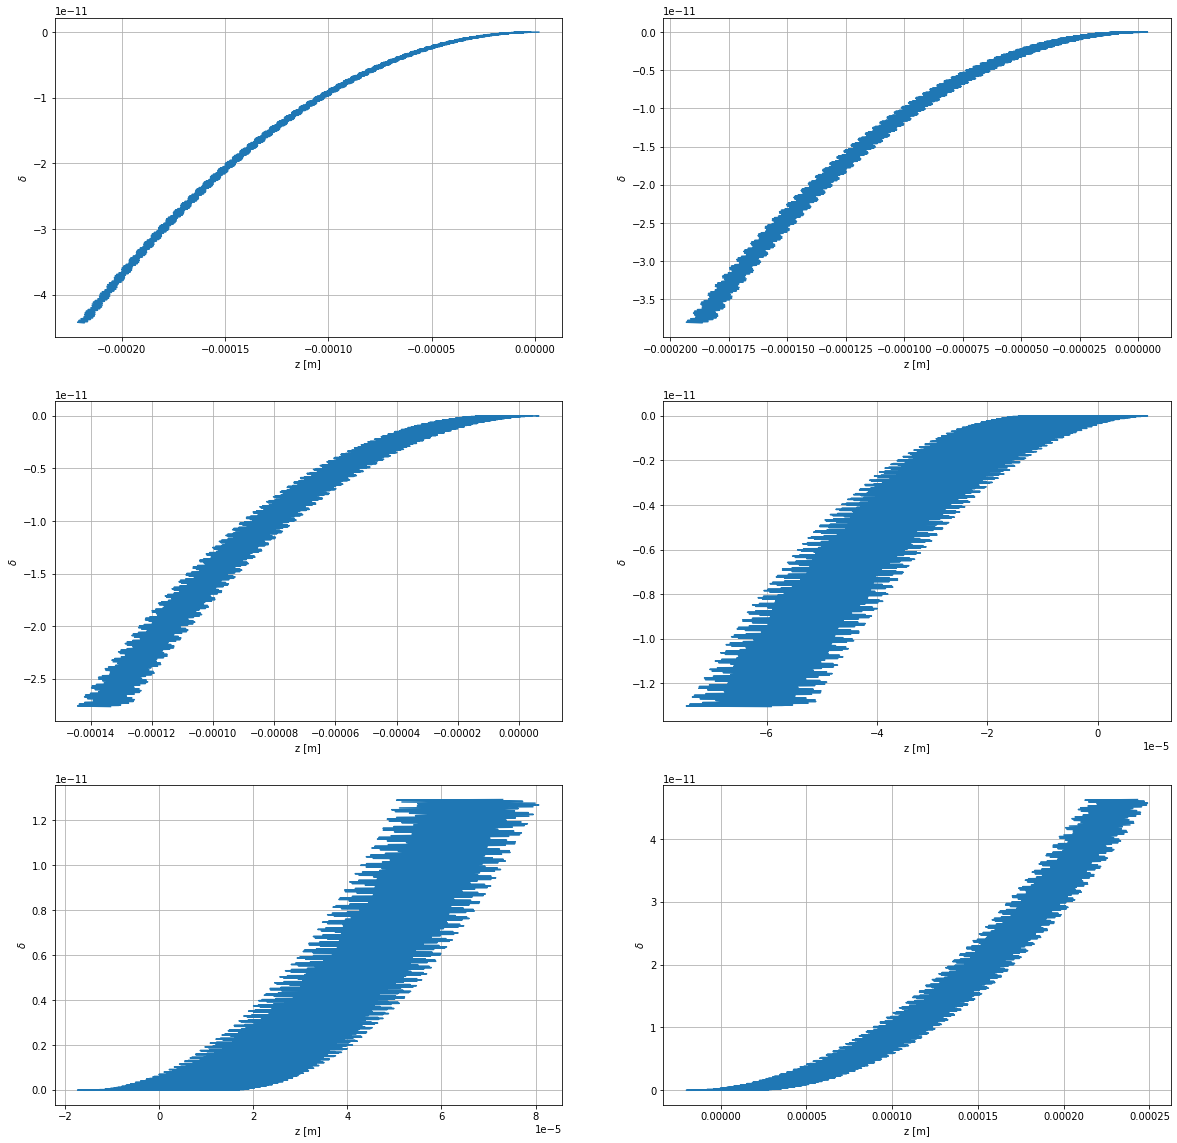

In [19]:
fig1 = plt.figure(1, figsize=(20, 20))

ztransverse1 = plt.subplot(3,2,1)
ztransverse1.plot(zeta[0], delta[0])
ztransverse1.set_xlabel('z [m]')
ztransverse1.set_ylabel('$\delta$')
ztransverse1.grid()

ztransverse2 = plt.subplot(3,2,2)
ztransverse2.plot(zeta[1], delta[1])
ztransverse2.set_xlabel('z [m]')
ztransverse2.set_ylabel('$\delta$')
ztransverse2.grid()

ztransverse3 = plt.subplot(3,2,3)
ztransverse3.plot(zeta[2], delta[2])
ztransverse3.set_xlabel('z [m]')
ztransverse3.set_ylabel('$\delta$')
ztransverse3.grid()

ztransverse4 = plt.subplot(3,2,4)
ztransverse4.plot(zeta[3], delta[3])
ztransverse4.set_xlabel('z [m]')
ztransverse4.set_ylabel('$\delta$')
ztransverse4.grid()

ztransverse5 = plt.subplot(3,2,5)
ztransverse5.plot(zeta[4], delta[4])
ztransverse5.set_xlabel('z [m]')
ztransverse5.set_ylabel('$\delta$')
ztransverse5.grid()

ztransverse6 = plt.subplot(3,2,6)
ztransverse6.plot(zeta[5], delta[5])
ztransverse6.set_xlabel('z [m]')
ztransverse6.set_ylabel('$\delta$')
ztransverse6.grid()

plt.show()

We need to study the x-y coupling. To do this we first try to have the same fractional tune on x and y.
The `dqx.b1_sq` and `dqy.b1_sq` knobs are what we need. Those who performed the optics measurements tell us that the fractional tune is .32, for example. We can use these knobs to change that.

**Important**: if we trim by 0.001 we won't see a 0.001 change, but something like 0.00098 for example, due to non linearities and coupling.

First of all let's see what is the tune of our machine. We can do this by twissing, as always.

In [127]:
line = xt.Line.from_madx_sequence(mad.sequence['lhcb1'],
                                  deferred_expressions=True
                                  )

In [128]:
tracker = xt.Tracker(_context=ctx, line=line);
tw = tracker.twiss(particles_3)
print('Qx = ',tw["qx"]%1,' Qy = ',tw["qy"]%1)

generating ./bcf2623201b6412b9497fa65d2297787.c
the current directory is '/home/afornara/studies/git_postprocessing'
running build_ext
building 'bcf2623201b6412b9497fa65d2297787' extension
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -I/home/afornara/py/2022_03_04/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -fPIC -I/home/afornara/py/2022_03_04/miniconda/include/python3.9 -c bcf2623201b6412b9497fa65d2297787.c -o ./bcf2623201b6412b9497fa65d2297787.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_03_04/minicon

So in this case the tunes are .313 and .318. We want to try to make them equal, for example by raising the qx by .0025 and lowering the qx by the same amount so that they meet at 0.3155. We will do this in steps of .0005.

First of all let's print the values of `dqx.b1_sq` and `dqy.b1_sq`.

In [129]:
print(line.vars['dqx.b1_sq']._get_value())
print(line.vars['dqy.b1_sq']._get_value())

0.00307360121499391
-0.00199038224134226


In [139]:
qxs = np.zeros(7)
qys = np.zeros(7)



line.vars['dqx.b1_sq'] = 0.00307360121499391
line.vars['dqy.b1_sq'] = -0.00199038224134226
tracker = xt.Tracker(_context=ctx, line=line)
tw = tracker.twiss(particles_3)
qxs[0]=tw["qx"]% 1
qys[0]=tw["qy"]% 1
print('Qx = ',tw["qx"]%1,' Qy = ',tw["qy"]%1)
if False:
    line.vars['dqx.b1_sq'] += 0.0024
    line.vars['dqy.b1_sq'] -= 0.0024
    tracker = xt.Tracker(_context=ctx, line=line)
    tw = tracker.twiss(particles_3)

for ii in range (6):
    line.vars['dqx.b1_sq'] += 0.0005
    line.vars['dqy.b1_sq'] -= 0.0005
    #tracker = xt.Tracker(_context=ctx, line=line)
    tw = tracker.twiss(particles_3)
    print('Qx = ',tw["qx"]%1,' Qy = ',tw["qy"]%1)
    qxs[ii+1]=tw["qx"]% 1
    qys[ii+1]=tw["qy"]% 1
print('Qx = ',tw["qx"]%1,' Qy = ',tw["qy"]%1)

generating ./b0d75d1bd3494d9fa877a339ea6e2d36.c
the current directory is '/home/afornara/studies/git_postprocessing'
running build_ext
building 'b0d75d1bd3494d9fa877a339ea6e2d36' extension
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -I/home/afornara/py/2022_03_04/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -fPIC -I/home/afornara/py/2022_03_04/miniconda/include/python3.9 -c b0d75d1bd3494d9fa877a339ea6e2d36.c -o ./b0d75d1bd3494d9fa877a339ea6e2d36.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_03_04/minicon

In [140]:
data = {'qx': qxs, 'qy': qys}
df = pd.DataFrame(data=data)
df

,qx,qy
0,0.313003,0.318000
1,0.313490,0.317513
2,0.313968,0.317034
3,0.314426,0.316576
4,0.314823,0.316179
5,0.316016,0.314986
6,0.316256,0.314746


Something is happening: lowering dqy and raising dqx to match qx and qy makes them become closer until a "jump" happens and qx becomes greater than qy. This is due to coupling, and we need to remove this coupling in order to be able to study the effects of octupoles and sextupoles in the machine.
To to this we can use the following knobs.

In [141]:
print(line.vars['cmrs.b1_sq']._get_value())
print(line.vars['cmis.b1_sq']._get_value())

0.000999999999768503
5.00227990246399e-10


The study has been performed in this way:
- We double cmrs and then we vary the tunes with discrete 0.0005 steps to find the closest approach;
- The tunes are even more spreaded than before->we have increased coupling;
- We halve cmrs and we repeat the procedure for discrete steps;
- Now the two are closing together and the crossing for some steps is shown in the figure.

Two things now must be done:
- We need to improve our method to find the closest approach, i.e. we need to find a minimization procedure;
- We **don't want** to work on the diagonal, we just want to use cmrs to find the closest approach, but, with the newly found cmrs, we want to go back to the original fractional tunes spreaded by $5x10^{-3}$: this is because the coupling on the diagonal is greatly enhanced by a number of unwanted effects that do not affect the off-diagonal so much.



In [150]:
line.vars['cmrs.b1_sq']=0.000999999999768503
line.vars['cmis.b1_sq']=5.00227990246399e-10


line.vars['cmrs.b1_sq']=0.5*line.vars['cmrs.b1_sq']
#line.vars['cmis.b1_sq']=2*line.vars['cmis.b1_sq']

In [151]:
qxs = np.zeros(7)
qys = np.zeros(7)




line.vars['dqx.b1_sq'] = 0.00307360121499391
line.vars['dqy.b1_sq'] = -0.00199038224134226
tracker = xt.Tracker(_context=ctx, line=line)
tw = tracker.twiss(particles_3)
qxs[0]=tw["qx"]% 1
qys[0]=tw["qy"]% 1
print('Qx = ',tw["qx"]%1,' Qy = ',tw["qy"]%1)
if False:
    line.vars['dqx.b1_sq'] += 0.0024
    line.vars['dqy.b1_sq'] -= 0.0024
    tracker = xt.Tracker(_context=ctx, line=line)
    tw = tracker.twiss(particles_3)

for ii in range (6):
    line.vars['dqx.b1_sq'] += 0.0005
    line.vars['dqy.b1_sq'] -= 0.0005
    #tracker = xt.Tracker(_context=ctx, line=line)
    tw = tracker.twiss(particles_3)
    print('Qx = ',tw["qx"]%1,' Qy = ',tw["qy"]%1)
    qxs[ii+1]=tw["qx"]% 1
    qys[ii+1]=tw["qy"]% 1
print('Qx = ',tw["qx"]%1,' Qy = ',tw["qy"]%1)

generating ./154355a81d1e479e93632f60e374a8bd.c
the current directory is '/home/afornara/studies/git_postprocessing'
running build_ext
building '154355a81d1e479e93632f60e374a8bd' extension
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -I/home/afornara/py/2022_03_04/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -fPIC -I/home/afornara/py/2022_03_04/miniconda/include/python3.9 -c 154355a81d1e479e93632f60e374a8bd.c -o ./154355a81d1e479e93632f60e374a8bd.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_03_04/minicon

In [152]:
data = {'qx': qxs, 'qy': qys}
df = pd.DataFrame(data=data)
df

,qx,qy
0,0.313053,0.317950
1,0.313552,0.317451
2,0.314050,0.316952
3,0.314547,0.316455
4,0.315038,0.315964
5,0.315641,0.315361
6,0.316070,0.314931


We found a point of close approach (line 5)! Now we move closer to that.

In [153]:
qxs = np.zeros(7)
qys = np.zeros(7)




line.vars['dqx.b1_sq'] = 0.00307360121499391
line.vars['dqy.b1_sq'] = -0.00199038224134226
tracker = xt.Tracker(_context=ctx, line=line)
tw = tracker.twiss(particles_3)

line.vars['dqx.b1_sq'] += 0.0023
line.vars['dqy.b1_sq'] -= 0.0023
#tracker = xt.Tracker(_context=ctx, line=line)
tw = tracker.twiss(particles_3)
qxs[0]=tw["qx"]% 1
qys[0]=tw["qy"]% 1
print('Qx = ',tw["qx"]%1,' Qy = ',tw["qy"]%1)


for ii in range (6):
    line.vars['dqx.b1_sq'] += 0.00003
    line.vars['dqy.b1_sq'] -= 0.00003
    #tracker = xt.Tracker(_context=ctx, line=line)
    tw = tracker.twiss(particles_3)
    print('Qx = ',tw["qx"]%1,' Qy = ',tw["qy"]%1)
    qxs[ii+1]=tw["qx"]% 1
    qys[ii+1]=tw["qy"]% 1
print('Qx = ',tw["qx"]%1,' Qy = ',tw["qy"]%1)

generating ./17e669eb341f4558a6eb4b48f6d5470f.c
the current directory is '/home/afornara/studies/git_postprocessing'
running build_ext
building '17e669eb341f4558a6eb4b48f6d5470f' extension
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -I/home/afornara/py/2022_03_04/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -fPIC -I/home/afornara/py/2022_03_04/miniconda/include/python3.9 -c 17e669eb341f4558a6eb4b48f6d5470f.c -o ./17e669eb341f4558a6eb4b48f6d5470f.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_03_04/minicon

In [154]:
data = {'qx': qxs, 'qy': qys}
df = pd.DataFrame(data=data)
df

,qx,qy
0,0.315308,0.315693
1,0.315329,0.315672
2,0.315347,0.315653
3,0.315362,0.315639
4,0.315371,0.315629
5,0.315630,0.315372
6,0.315634,0.315368


So let's see: we started with a closest approach of qx=0.314823,qy=0.316179 before the jump occurs and, thanks to the cmrs tweaking we were able to get qx=0.315371, qy=0.315629, way better!

Let's plot this crossing.


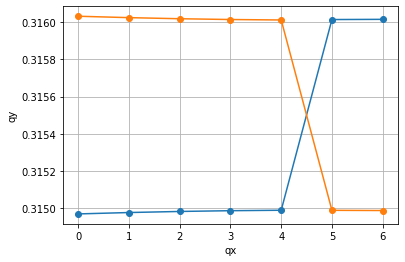

In [147]:
plt.plot(qxs,'-o')
plt.plot(qys,'-o')
plt.grid()
plt.xlabel('qx')
plt.ylabel('qy');
#plt.ylim(0.312,0.315)

So let's define our point of work:

In [155]:
line.vars['cmrs.b1_sq']=0.000999999999768503
line.vars['cmis.b1_sq']=5.00227990246399e-10
line.vars['cmrs.b1_sq']=0.5*line.vars['cmrs.b1_sq']

line.vars['dqx.b1_sq'] = 0.00307360121499391
line.vars['dqy.b1_sq'] = -0.00199038224134226
tracker = xt.Tracker(_context=ctx, line=line)
tw = tracker.twiss(particles_3)
print('Qx = ',tw["qx"]%1,' Qy = ',tw["qy"]%1)

generating ./d4b1a8d3afd749b9979869dc7e250429.c
the current directory is '/home/afornara/studies/git_postprocessing'
running build_ext
building 'd4b1a8d3afd749b9979869dc7e250429' extension
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -I/home/afornara/py/2022_03_04/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_04/miniconda/include -fPIC -I/home/afornara/py/2022_03_04/miniconda/include/python3.9 -c d4b1a8d3afd749b9979869dc7e250429.c -o ./d4b1a8d3afd749b9979869dc7e250429.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_04/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -L/home/afornara/py/2022_03_04/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_03_04/minicon

Now we can perform the simulation again, with the machine uncoupled.

In [156]:
particles = xp.build_particles(_context=ctx2, particle_ref=p0, x=[p0.x+0.3*sigma_x,p0.x+0.6*sigma_x,p0.x+0.9*sigma_x,
                                                                 p0.x+1.2*sigma_x,p0.x+1.6*sigma_x,p0.x+2.0*sigma_x])
tracker = xt.Tracker(_context=ctx2, line=line)
tw = tracker.twiss(particles_3)
print('Qx = ',tw["qx"]%1,' Qy = ',tw["qy"]%1)
N=1000
#I'm tracking 6 particles in this case
N_particles=6
n_turns=1

x = [[0 for turns in range(N)] for protons in range(N_particles)] 
px = [[0 for turns in range(N)] for protons in range(N_particles)] 
y = [[0 for turns in range(N)] for protons in range(N_particles)] 
py = [[0 for turns in range(N)] for protons in range(N_particles)] 
zeta = [[0 for turns in range(N)] for protons in range(N_particles)] 
delta = [[0 for turns in range(N)] for protons in range(N_particles)] 

for ii in range(N):
    tracker.track(particles, num_turns=n_turns,turn_by_turn_monitor=False)
    for jj in range(N_particles):
        x[jj][ii] = ctx2.nparray_from_context_array(particles.x)[jj]
        px[jj][ii] = ctx2.nparray_from_context_array(particles.px)[jj]
        y[jj][ii] = ctx2.nparray_from_context_array(particles.y)[jj]
        py[jj][ii] = ctx2.nparray_from_context_array(particles.py)[jj]
        zeta[jj][ii] = ctx2.nparray_from_context_array(particles.zeta)[jj]
        delta[jj][ii] = ctx2.nparray_from_context_array(particles.delta)[jj]

Qx =  0.3130526815424801  Qy =  0.3179498555139091


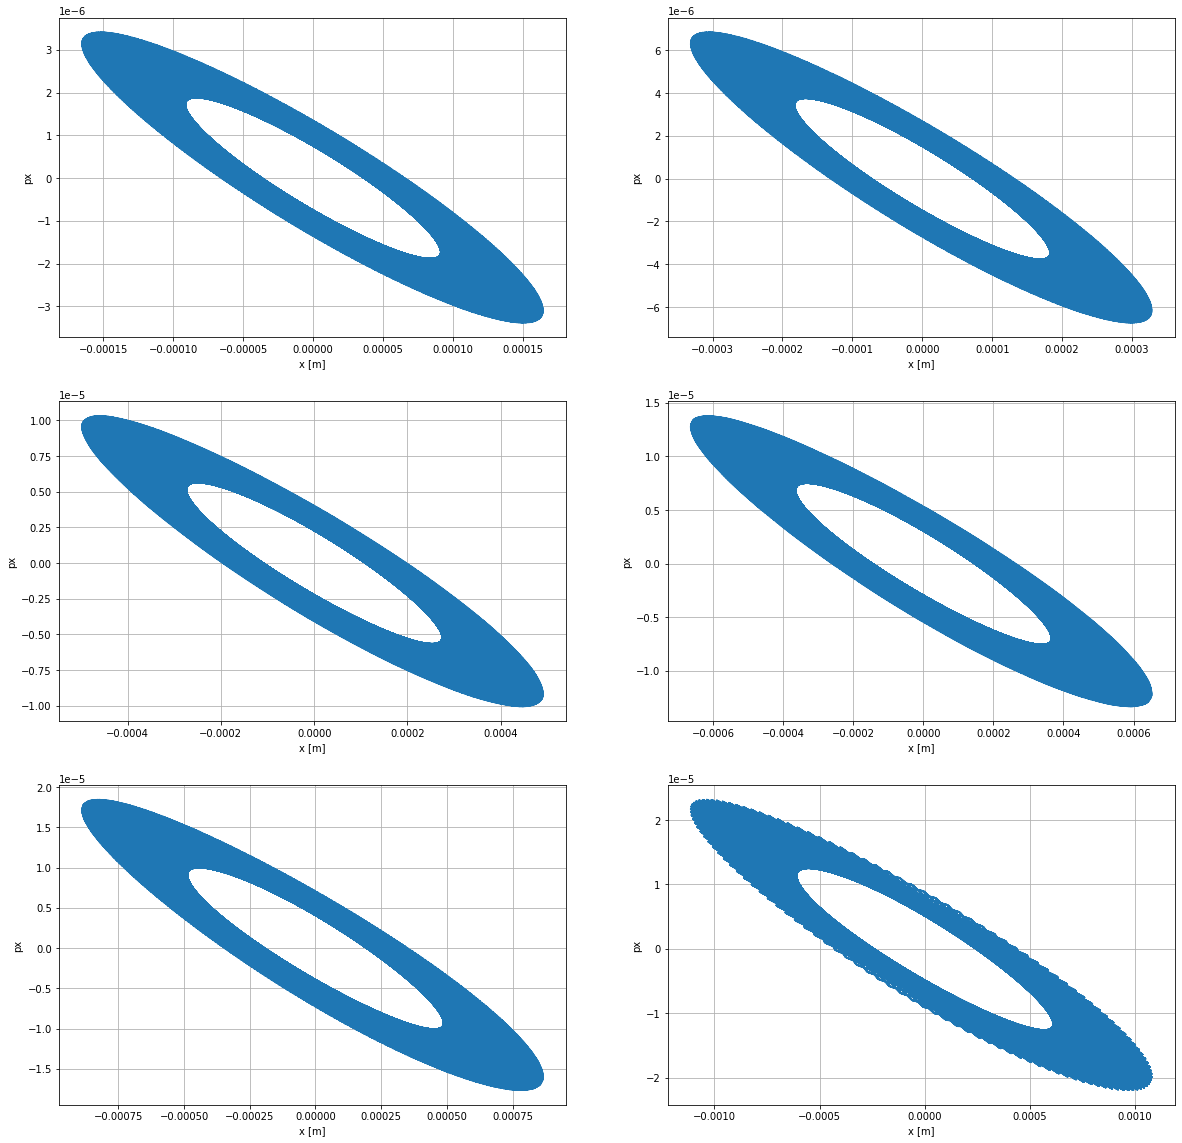

In [157]:
fig1 = plt.figure(1, figsize=(20, 20))

xtransverse1 = plt.subplot(3,2,1)
xtransverse1.plot(x[0], px[0])
xtransverse1.set_xlabel('x [m]')
xtransverse1.set_ylabel('px')
xtransverse1.grid()

xtransverse2 = plt.subplot(3,2,2)
xtransverse2.plot(x[1], px[1])
xtransverse2.set_xlabel('x [m]')
xtransverse2.set_ylabel('px')
xtransverse2.grid()

xtransverse3 = plt.subplot(3,2,3)
xtransverse3.plot(x[2], px[2])
xtransverse3.set_xlabel('x [m]')
xtransverse3.set_ylabel('px')
xtransverse3.grid()

xtransverse4 = plt.subplot(3,2,4)
xtransverse4.plot(x[3], px[3])
xtransverse4.set_xlabel('x [m]')
xtransverse4.set_ylabel('px')
xtransverse4.grid()

xtransverse5 = plt.subplot(3,2,5)
xtransverse5.plot(x[4], px[4])
xtransverse5.set_xlabel('x [m]')
xtransverse5.set_ylabel('px')
xtransverse5.grid()

xtransverse6 = plt.subplot(3,2,6)
xtransverse6.plot(x[5], px[5])
xtransverse6.set_xlabel('x [m]')
xtransverse6.set_ylabel('px')
xtransverse6.grid()

plt.show()

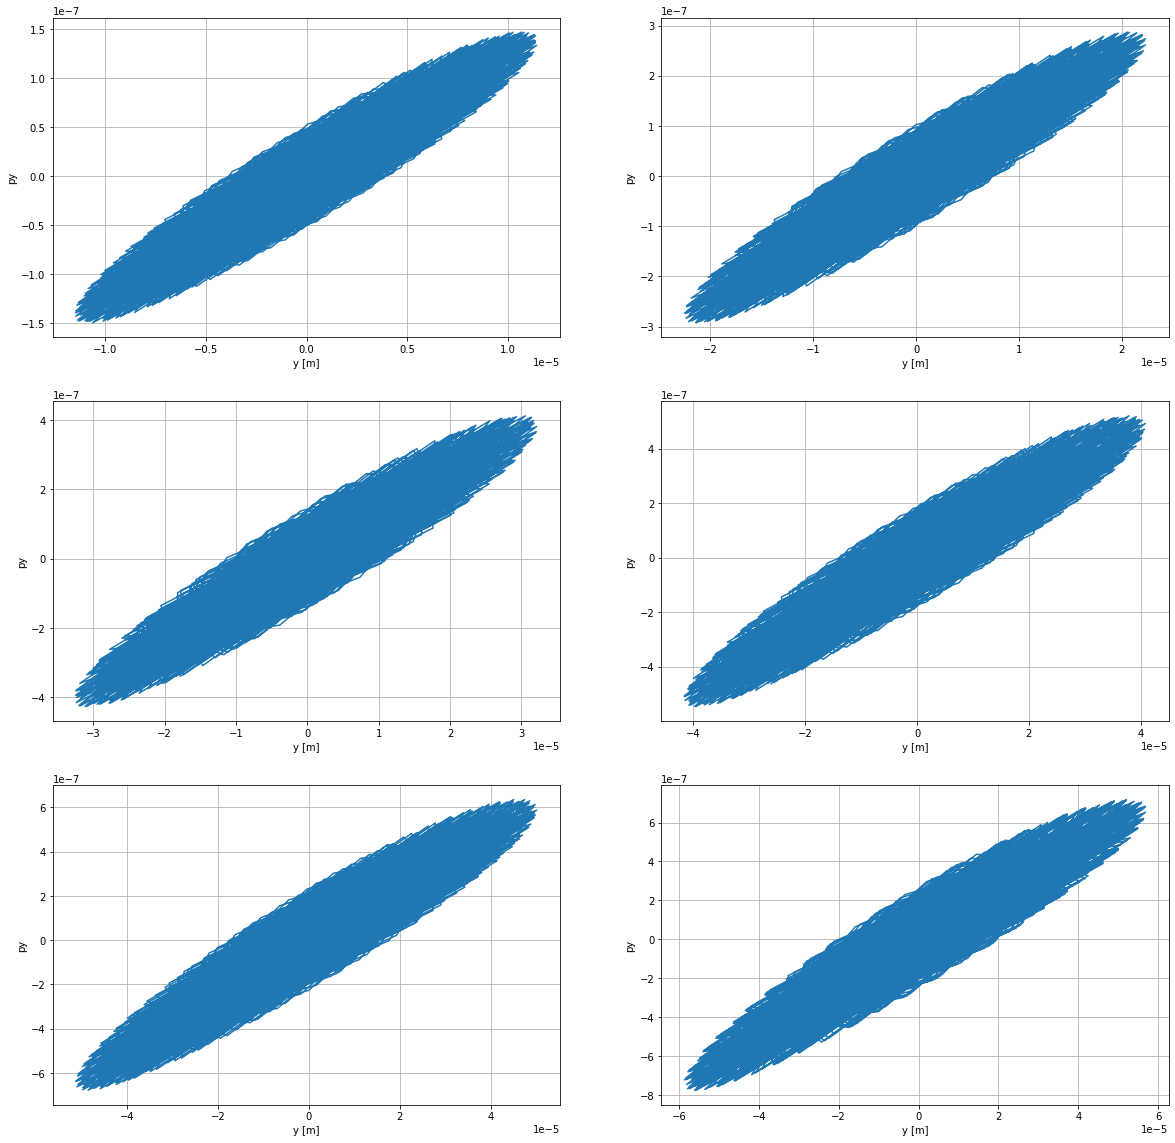

In [158]:
fig1 = plt.figure(1, figsize=(20, 20))

ytransverse1 = plt.subplot(3,2,1)
ytransverse1.plot(y[0], py[0])
ytransverse1.set_xlabel('y [m]')
ytransverse1.set_ylabel('py')
ytransverse1.grid()

ytransverse2 = plt.subplot(3,2,2)
ytransverse2.plot(y[1], py[1])
ytransverse2.set_xlabel('y [m]')
ytransverse2.set_ylabel('py')
ytransverse2.grid()

ytransverse3 = plt.subplot(3,2,3)
ytransverse3.plot(y[2], py[2])
ytransverse3.set_xlabel('y [m]')
ytransverse3.set_ylabel('py')
ytransverse3.grid()

ytransverse4 = plt.subplot(3,2,4)
ytransverse4.plot(y[3], py[3])
ytransverse4.set_xlabel('y [m]')
ytransverse4.set_ylabel('py')
ytransverse4.grid()

ytransverse5 = plt.subplot(3,2,5)
ytransverse5.plot(y[4], py[4])
ytransverse5.set_xlabel('y [m]')
ytransverse5.set_ylabel('py')
ytransverse5.grid()

ytransverse6 = plt.subplot(3,2,6)
ytransverse6.plot(y[5], py[5])
ytransverse6.set_xlabel('y [m]')
ytransverse6.set_ylabel('py')
ytransverse6.grid()

plt.show()

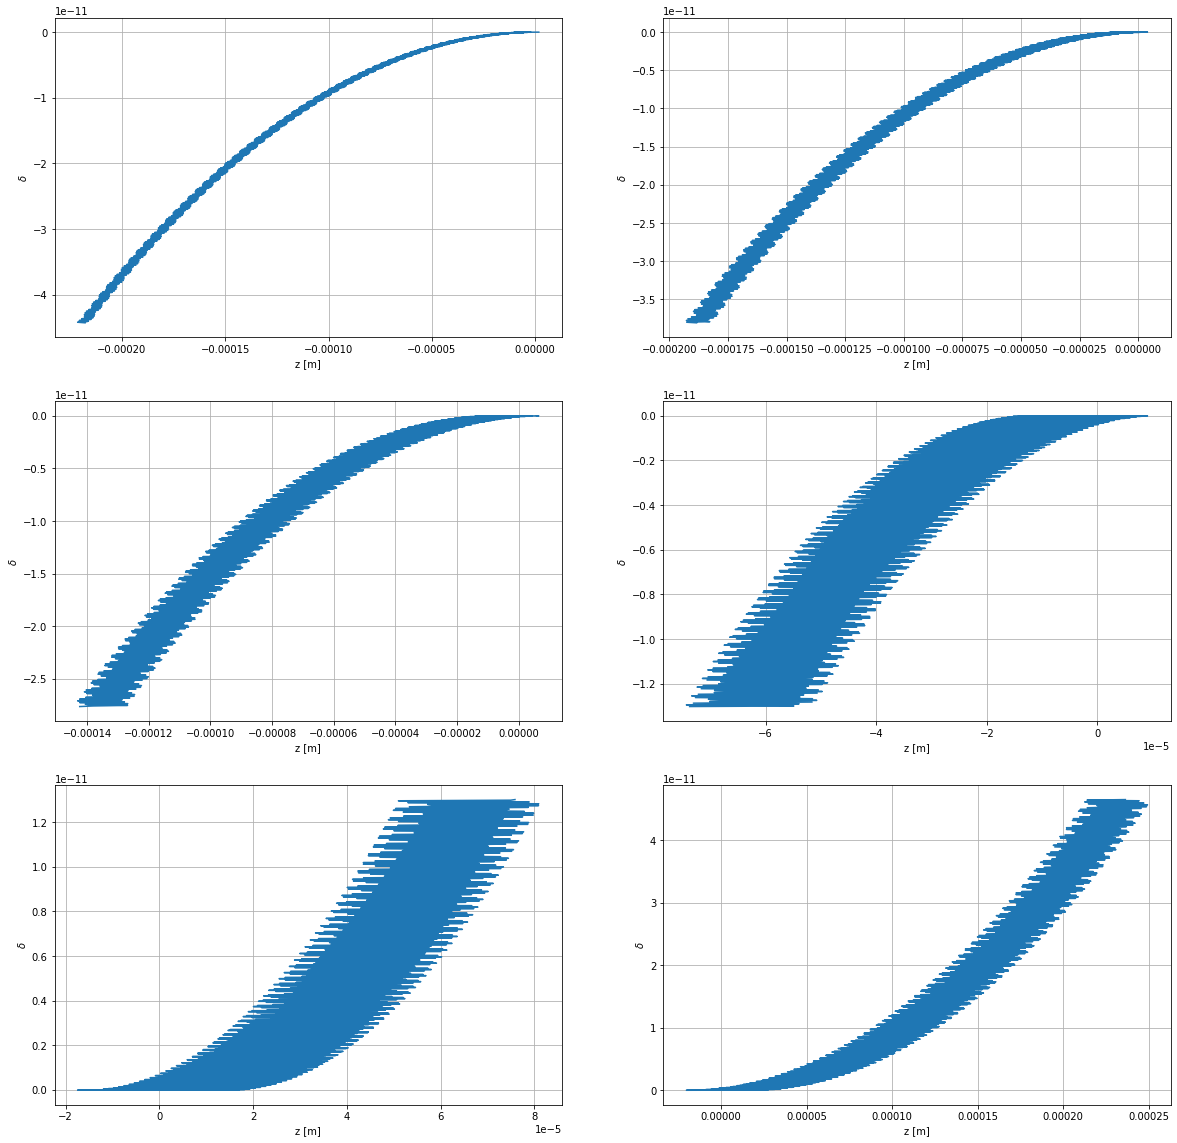

In [159]:
fig1 = plt.figure(1, figsize=(20, 20))

ztransverse1 = plt.subplot(3,2,1)
ztransverse1.plot(zeta[0], delta[0])
ztransverse1.set_xlabel('z [m]')
ztransverse1.set_ylabel('$\delta$')
ztransverse1.grid()

ztransverse2 = plt.subplot(3,2,2)
ztransverse2.plot(zeta[1], delta[1])
ztransverse2.set_xlabel('z [m]')
ztransverse2.set_ylabel('$\delta$')
ztransverse2.grid()

ztransverse3 = plt.subplot(3,2,3)
ztransverse3.plot(zeta[2], delta[2])
ztransverse3.set_xlabel('z [m]')
ztransverse3.set_ylabel('$\delta$')
ztransverse3.grid()

ztransverse4 = plt.subplot(3,2,4)
ztransverse4.plot(zeta[3], delta[3])
ztransverse4.set_xlabel('z [m]')
ztransverse4.set_ylabel('$\delta$')
ztransverse4.grid()

ztransverse5 = plt.subplot(3,2,5)
ztransverse5.plot(zeta[4], delta[4])
ztransverse5.set_xlabel('z [m]')
ztransverse5.set_ylabel('$\delta$')
ztransverse5.grid()

ztransverse6 = plt.subplot(3,2,6)
ztransverse6.plot(zeta[5], delta[5])
ztransverse6.set_xlabel('z [m]')
ztransverse6.set_ylabel('$\delta$')
ztransverse6.grid()

plt.show()

In [126]:
#qxs = np.zeros(7)
#qys = np.zeros(7)
if False:
    qxs = []
    qys = []


    line.vars['dqx.b1_sq'] = 0.00307360121499391
    line.vars['dqy.b1_sq'] = -0.00199038224134226
    tracker = xt.Tracker(_context=ctx, line=line)
    tw = tracker.twiss(particles_3)
    qxs.append(tw["qx"]% 1)
    qys.append(tw["qy"]% 1)
    print('Qx = ',qxs[0],' Qy = ',qys[0])

    diff=(tw["qx"]% 1)-(tw["qy"]% 1)

    print(diff)
    while abs(diff) > 0.0002:
        line.vars['dqx.b1_sq'] = 0.00307360121499391
        line.vars['dqy.b1_sq'] = -0.00199038224134226
        line.vars['cmrs.b1_sq']=0.8*line.vars['cmrs.b1_sq']
        print('cmrs = ',line.vars['cmrs.b1_sq']._get_value())
        for ii in range(15):
            print('ii=',ii)
            line.vars['dqx.b1_sq'] += 0.001
            line.vars['dqy.b1_sq'] -= 0.001
            tw = tracker.twiss(particles_3)
            qxs.append(tw["qx"]% 1)
            qys.append(tw["qy"]% 1)
            diff2=(tw["qx"]% 1)-(tw["qy"]% 1)
            if(abs(diff2)<abs(diff)):
                get_dqx=line.vars['dqx.b1_sq']
                get_dqy=line.vars['dqy.b1_sq']
                diff=diff2
                print('|qx-qy| = ',abs(diff))
            if(abs(diff) < 0.001):
                    line.vars['dqx.b1_sq']=get_dqx
                    line.vars['dqy.b1_sq']=get_dqy
                    count = 0
                    for jj in range(10):
                        print('jj=',jj)
                        line.vars['dqx.b1_sq'] += 0.0001
                        line.vars['dqy.b1_sq'] -= 0.0001
                        print(line.vars['dqx.b1_sq']._get_value())
                        print(line.vars['dqy.b1_sq']._get_value())
                        tw = tracker.twiss(particles_3)
                        qxs.append(tw["qx"]% 1)
                        qys.append(tw["qy"]% 1)
                        diff2=(tw["qx"]% 1)-(tw["qy"]% 1)
                        count+=1
                        if(abs(diff2)<abs(diff)):
                            count = 0
                            diff=diff2
                            print('|qx-qy| = ',abs(diff))
                        if(count==3):
                            break

In [ ]:

#Scorrere sugli ottupoli
sum_nl = 0.0
count_nl = 0
sum_sl = 0.0
count_sl = 0
for elem in line.element_dict :
    if isinstance(line.element_dict[elem],xt.beam_elements.elements.Multipole):   
        if(line.element_dict[elem].order==3):
                #i print sono giusti, li commento perché sono lunghi
                sum_nl+=line.element_dict[elem].knl[3]
                count_nl+=1
                sum_sl+=line.element_dict[elem].ksl
                count_sl+=1
                #print(elem)
                #print(line.element_dict[elem].knl)
                
        if(line.element_dict[elem].order==2):
                #i print sono giusti, li commento perché sono lunghi
                sum_nl+=line.element_dict[elem].knl[2]
                count_nl+=1
                #print(elem)
                #print(line.element_dict[elem].knl)
K_OCT = sum_nl/count_nl
K_OCT

In [ ]:
particles_3 = xp.Particles(_context=ctx,
                        p0c=7000e9,
                        x=[1.00951707e-08],px=[1.69518015e-10],
                        y=[5.65551848e-12],py=[6.07695199e-14]
                        )

In [ ]:
tracker1 = xt.Tracker(_context=ctx, line=line)
tw1 = tracker1.twiss(particles_3)
tracker2 = xt.Tracker(_context=ctx, line=line)
tw2 = tracker2.twiss(particles_3)
tracker3 = xt.Tracker(_context=ctx, line=line)
tw3 = tracker3.twiss(particles_3)
tracker4 = xt.Tracker(_context=ctx, line=line)
tw4 = tracker4.twiss(particles_3)
tracker5 = xt.Tracker(_context=ctx, line=line)
tw5 = tracker5.twiss(particles_3)

In [ ]:
gamma=7000/.938
sigma_x=np.sqrt(120.29057045*3e-6/gamma)
sigma_x
n_turns = 1
N_arr=10000
#x_part0 = np.zeros(N_arr)
x_part1 = np.zeros(N_arr)
x_part2 = np.zeros(N_arr)
x_part3 = np.zeros(N_arr)
x_part4 = np.zeros(N_arr)
x_part5 = np.zeros(N_arr)

#co_part=tw['particle_on_co']
near_co_particle1=tw1['particle_on_co']
near_co_particle2=tw2['particle_on_co']
near_co_particle3=tw3['particle_on_co']
near_co_particle4=tw4['particle_on_co']
near_co_particle5=tw5['particle_on_co']


if False:
    for ii in range(N_arr):
        tracker.track(co_part, num_turns=n_turns,turn_by_turn_monitor=False)
        #print(particles_3.x)
        x_part0[ii]=co_part.x

positions = np.zeros(4)    
near_co_particle1.x=near_co_particle1.x+1e-5
near_co_particle2.x=near_co_particle2.x+1*sigma_x
near_co_particle3.x=near_co_particle3.x+2*sigma_x
near_co_particle4.x=near_co_particle4.x+3*sigma_x
near_co_particle5.x=near_co_particle5.x+4*sigma_x

positions[0]=near_co_particle2.x-near_co_particle1.x
positions[1]=near_co_particle3.x-near_co_particle1.x
positions[2]=near_co_particle4.x-near_co_particle1.x
positions[3]=near_co_particle5.x-near_co_particle1.x

if False:
    for ii in range(N_arr):
        tracker1.track(near_co_particle1, num_turns=n_turns,turn_by_turn_monitor=False)
        x_part1[ii]=near_co_particle1.x
        #print(x_part1[ii])
for ii in range(N_arr):
    tracker2.track(near_co_particle2, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part2[ii]=near_co_particle2.x
    #print(x_part2[ii])
for ii in range(N_arr):
    tracker3.track(near_co_particle3, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part3[ii]=near_co_particle3.x
    #print(x_part3[ii])
for ii in range(N_arr):
    tracker4.track(near_co_particle4, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part4[ii]=near_co_particle4.x
for ii in range(N_arr):
    tracker5.track(near_co_particle5, num_turns=n_turns,turn_by_turn_monitor=False)
    x_part5[ii]=near_co_particle5.x
    #print(x_part5[ii])
    
#print(x_part1[ii])

In [ ]:
#Max_reco_freq= sampling frequency/2.
plt.figure()
#plt.plot(np.linspace(0,1,len(x_part0)), np.abs(np.fft.fft(x_part0)), 'b')
#plt.plot(np.linspace(0,1,len(x_part1)), np.abs(np.fft.fft(x_part1)), 'c')
plt.plot(np.linspace(0,1,len(x_part2)), np.abs(np.fft.fft(x_part2)), 'm')
plt.plot(np.linspace(0,1,len(x_part3)), np.abs(np.fft.fft(x_part3)), 'y')
plt.plot(np.linspace(0,1,len(x_part4)), np.abs(np.fft.fft(x_part4)), 'g')
plt.plot(np.linspace(0,1,len(x_part5)), np.abs(np.fft.fft(x_part5)), 'r')
plt.xlabel('Q1 from X')
plt.ylabel('FFT amplitude [arb. units]')
plt.xlim(0.312,0.314)
plt.grid()
#print(np.abs(np.fft.fft(x_part)))

In [ ]:
#q0 = NAFFlib.get_tune(x_part0)
q1 = NAFFlib.get_tune(x_part1)
q2 = NAFFlib.get_tune(x_part2)
q3 = NAFFlib.get_tune(x_part3)
q4 = NAFFlib.get_tune(x_part4)
q5 = NAFFlib.get_tune(x_part5)
print('q1 =',q1,'q2 =', q2, ', q3 =', q3, ', q4 =', q4,', q5 =', q5)
tunes = np.zeros(4)
#tunes[0]=q0
#tunes[0]=q1
tunes[0]=q2
tunes[1]=q3
tunes[2]=q4
tunes[3]=q5
#positions[0]=x_part0[0] 
#positions[0]=near_co_particle1.x+0.2*sigma_x

#print(positions[1],tunes[1])

In [ ]:
plt.plot(positions,tunes,'.')
plt.grid()
plt.xlabel('dx')
plt.ylabel('tunes');
#plt.ylim(0.312,0.315)